# Import necessary libraries

In [3]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Get the pretrained model from tesorflow hub

In [4]:
IMAGE_SHAPE = (224,224)
classifier = tf.keras.Sequential([
                                  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

##  Get the flowers dataset from googleapis

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)
data_dir

228827136/228813984 [==============================] - 74s 0us/step


'.\\datasets\\flower_photos'

## Read the directory where the flowers dataset is saved

In [7]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [9]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

##  Create a dictionary containing all the flowers

In [11]:
flowers_image_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

##  label the flowers for classification

In [15]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}

##  Reshape all the images to 224 * 224 * 3

In [16]:
img = cv2.imread(str(flowers_image_dict['roses'][0]))
img.shape

(240, 179, 3)

In [17]:
cv2.resize(img,IMAGE_SHAPE).shape

(224, 224, 3)

In [19]:
X, y = [], []

for flower_name, images in flowers_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [23]:
X = np.array(X)
y = np.array(y)

## Split the dataset into training and testing

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##  Scale the dataset images

In [27]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

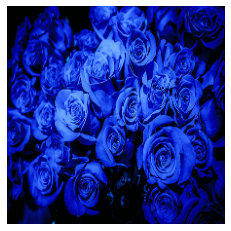

In [30]:
plt.axis('off')
plt.imshow(X[2])

##  Predict the class of flowers before retraining the model 

In [31]:
predicted = classifier.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 880, 795], dtype=int64)

##  Retrain the model

In [32]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrainded_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224,224,3), trainable=False)

In [34]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrainded_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x00000256A7366F40>>

In [38]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 33s 362ms/step - loss: 0.8494 - acc: 0.6897
Epoch 2/5
86/86 [==============================] - 31s 366ms/step - loss: 0.4202 - acc: 0.8630
Epoch 3/5
86/86 [==============================] - 29s 343ms/step - loss: 0.3273 - acc: 0.8921
Epoch 4/5
86/86 [==============================] - 30s 344ms/step - loss: 0.2711 - acc: 0.9132
Epoch 5/5
86/86 [==============================] - 29s 343ms/step - loss: 0.2332 - acc: 0.9320


In [39]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 10s 319ms/step - loss: 0.3986 - acc: 0.8486


[0.39864906668663025, 0.8485838770866394]